# **Notebook enviroment setup**


Initially, my plan was to fork the benchmark repository to my GitHub account and push my models and YAML files there, making it easier to present without a lengthy notebook. However, this approach didn't work. Consequently, I've decided to present this project using the original MOABB repository, starting from scratch. This decision will significantly lengthen the notebook, as all the code will be written directly within this document.

-*Report section*: I will only present the code I modified. since it is a demostration and not included in run time. I will comment them out

-*code section*: I will present the full version of code that is reproducible

In [ ]:
%%capture
# Installing SpeechBrain via pip
BRANCH = 'develop'
!python -m pip install git+https://github.com/speechbrain/speechbrain.git@$BRANCH

# Clone SpeechBrain repository
!git clone https://github.com/speechbrain/speechbrain/

In [ ]:
%%capture
!git clone https://github.com/speechbrain/benchmarks
%cd /content/benchmarks
!git checkout eeg

%cd /content/benchmarks/benchmarks/MOABB
!pip install -r extra-requirements.txt # Install additional dependencies

# **Enhenced EEGNET with Adaptive Pooling and Attention Layer**

## **Report Section**

## **Introduction**
*-Challenges*

Motor imagery training utilizing EEG data plays a crucial role in the advancement of brain-computer interfaces (BCIs) and rehabilitation technologies.EEG signal processing encounters several challenges, including noise from various sources like muscle movements and electrical interference, which can degrade signal quality. The non-stationary nature of EEG signals complicates their analysis with traditional methods, necessitating advanced techniques to handle their time-varying properties. Volume conduction and electrode reference issues add further complexity by mixing signals from multiple brain sources and varying with electrode placement. Additionally, individual differences in anatomy and the need for expert interpretation make EEG analysis intricate.(MDPI, 2023)


-*Recent Studies*

Recent studies have demonstrated various methods to enhance classification accuracy and speed for MI tasks. Techniques such as adding Gaussian noise, using algorithms like KNN and LDA, and employing mixed feature majority vote classifiers have shown significant improvements in recognizing MI EEG signals. These advancements contribute to the effectiveness of BCIs in therapeutic settings, optimizing signal processing and classification strategies (MDPI, 2023).

*-My Model*

My novel approach, "MyModel," incorporates an attention layer and adaptive average pooling layer within the EEGNet architecture, enhancing the model's focus on critical EEG signal features related to different motor imagery tasks. This enhancement addresses previous models' limitations by improving feature selection and interpretability. Preliminary tests on a standard motor imagery dataset show that MyModel outperforms previous version, includes adding a pooling layers. These findings suggest that integrating attention mechanisms could significantly refine the accuracy and responsiveness of EEG-based BCIs, promising substantial advancements in real-time neural decoding for therapeutic applications.


# **Methodology**

# **1. First Trial: Adding Adaptive pooling layer on EEGNET architecture**
The first model we adds a global average adaptive pooling. It was added right before the dense layer. This addition is particularly advantageous for EEG data analysis. By averaging over all spatial dimensions, this pooling layer extracts the most essential features from the entire set of feature maps. This is particularly useful in EEG processing where the spatial characteristics of the brain's electrical activity are critical. The pooling effectively distills this information into a format that emphasizes global patterns that are more indicative of the cognitive states or neurological conditions being studied.
# -Design inspiration and literature reference
A study about Lightweight Neural Network highlights the utility of adaptive average pooling in dynamic convolutional networks, noting that it effectively reduces redundancy while preserving spatial information, which is crucial for processing detailed data like images or EEG signals. This adaptive approach allows the network to maintain high performance even with varying input sizes, making it particularly useful for applications that need to handle diverse datasets.

below is the code we add for adaptive pooling layer, it is right before the dense layer



```
self.conv_module.add_module("gap", torch.nn.AdaptiveAvgPool2d((1, 1)))
```



# **2.Second Trial: Adding Attention Layer and Adaptive pooling layer on EEGNET architecture**
The second model is based on the first model by adding an attention layer on EEGNET architecture.
# -Design inspiration and literature reference
This design is inspired by GDNet-EEG (Wan et al., 2023). it is an attention-aware deep neural network based on group depth-wise convolution for SSVEP stimulation frequency recognition. the attention-aware deep neural network is consists of Group depth-wise convolution. It is proposed to extract temporal and spectral features from the EEG signal of each brain region and represent regional characteristics as diverse as possible. Furthermore, EEG attention consisting of EEG channel-wise attention and specialized network-wise attention is designed to identify essential brain regions and form significant feature maps as specialized brain functional networks. Two publicly SSVEPs datasets (large-scale benchmark and BETA dataset) and their combined dataset are utilized to validate the classification performance of our model.It achieves the highest classification accuracy of 84.11, 85.93, and 93.35% on the benchmark compare with other EEG architecture (Wan et al., 2023). The models that are being compared are EEGNET(Lawhern et al., 2018), Compact-CNN(Waytowich et al., 2018),DeepConvNet(Schirrmeister et al., 2017),Shallow ConvNet(Schirrmeister et al., 2017), Convolutional correlation analysis (Li et al., 2020),FB-SSVEPformer(Chen et al., 2022c), Filter bank CCA(Chen et al., 2022c)  

In the second trial, the positioning of adaptive pooling layer keeps the same and we add an attention layer in between the convoluntional layer and dense layer without bach normalization



```
self.attention_module = torch.nn.Sequential()
self.attention_module.add_module(
        'atten', PositionalwiseFeedForward(25, input_size=1),
      )
```



It contains a shape adjustment at the forward methods



```
def forward(self, x):
        """Returns the output of the model.

       Arguments
       ---------
        x : torch.Tensor (batch, time, EEG channel, channel)
            Input to convolve. 4d tensors are expected.
        """

       x = self.conv_module(x)
    # Check dimensions after GAP, adjust if necessary
      #if x.ndim > 3:
         x = torch.squeeze(x, -1)  # Squeeze the spatial dimension
       if x.ndim < 3:
          x = x.unsqueeze(-1)
        x = self.attention_module(x)
        x = self.dense_module(x)
       return x
```

I will also present the architecture of 'my model' Below

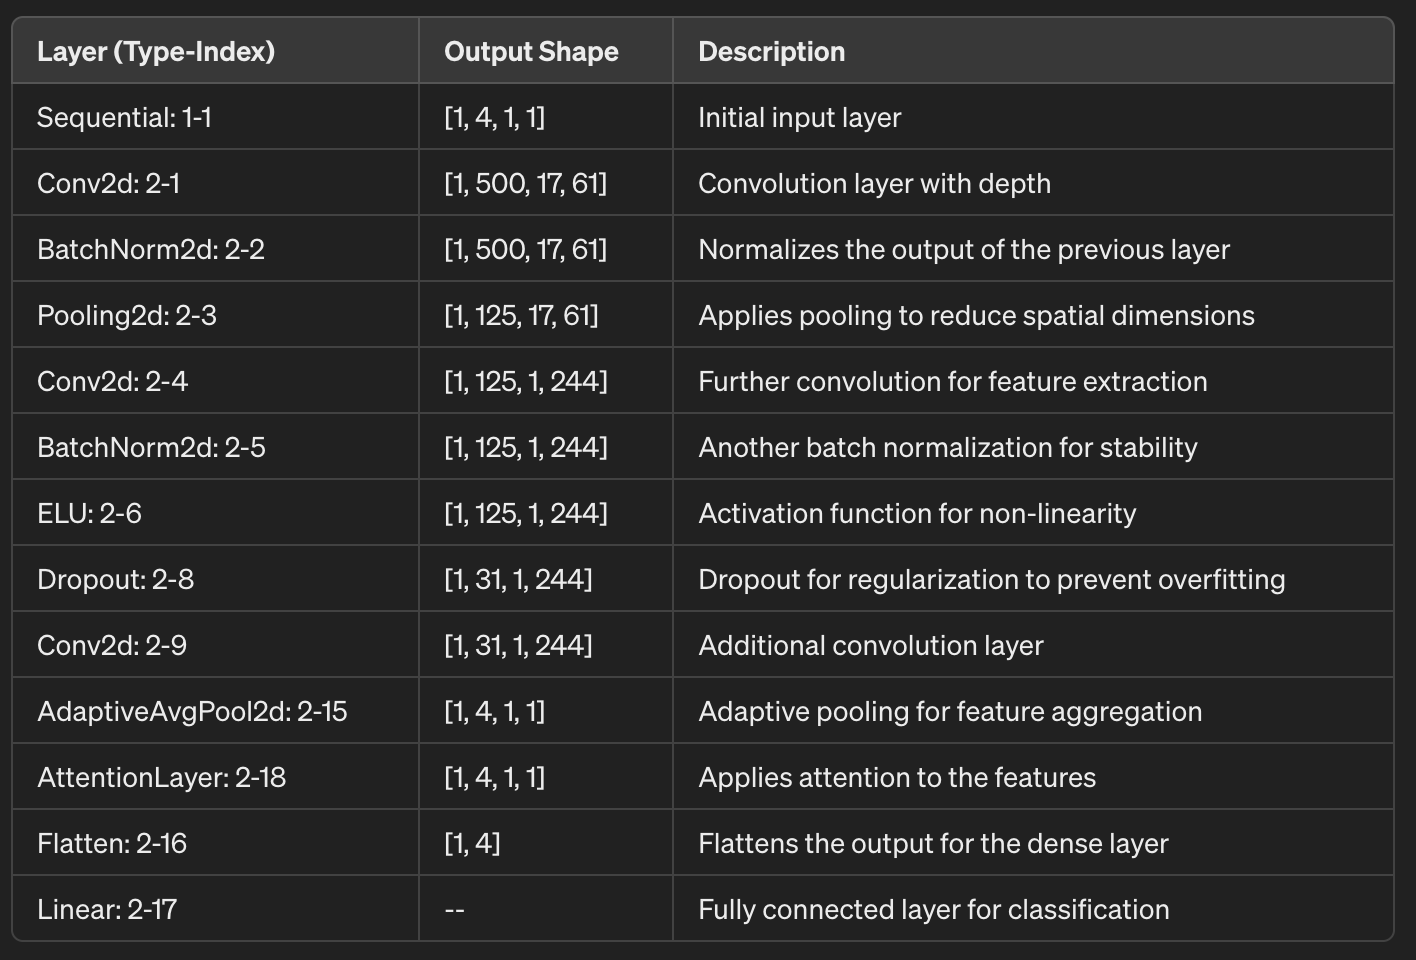

Note: above image is generated by chatgpt

## **Experimental Setup**


the dataset comprises EEG recordings from 9 subjects participating in a brain-computer interface (BCI) study focused on motor imagery tasks. These tasks include imagining movements of the left hand, right hand, both feet, and the tongue, categorized respectively as class 1, class 2, class 3, and class 4.(Tangermann et al., 2012)

# Recording Sessions and Trials:

Each subject attended two separate sessions on different days.
Each session consisted of six runs, with short breaks in between to ensure subject comfort and data integrity.
Every run included 48 trials, distributed equally among the four classes, resulting in 288 trials per session.(Tangermann et al., 2012)
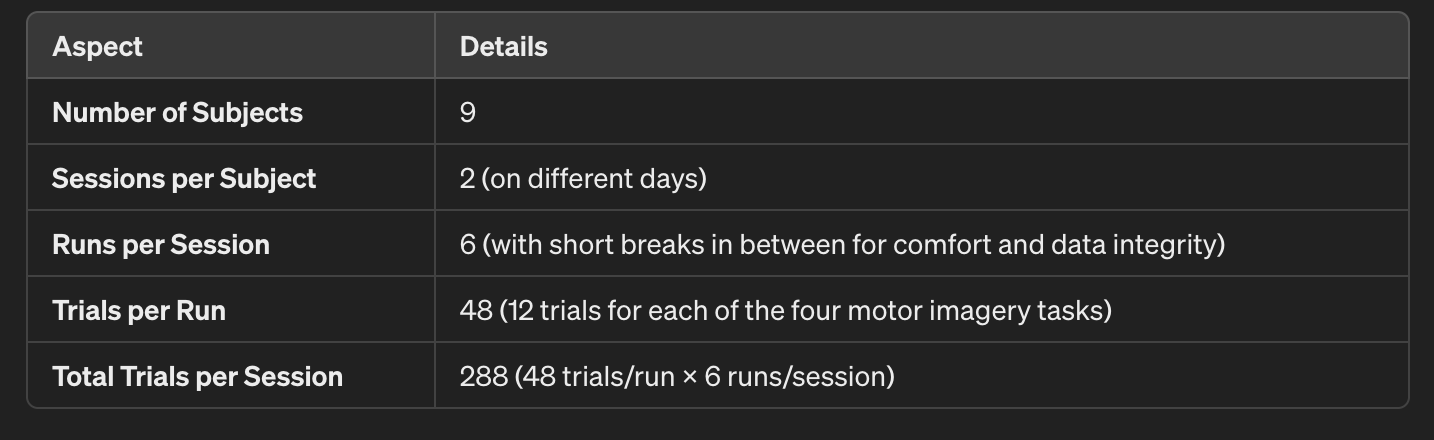

# Procedure and Visual Cues:

Trials began with a fixation cross displayed on a screen, accompanied by an acoustic warning tone at time 𝑡=0 seconds.
At 𝑡=2 seconds, an arrow appeared pointing in one of four directions, each direction corresponding to one of the motor imagery tasks. This visual cue remained visible for 1.25 seconds.
Subjects were instructed to perform the motor imagery task associated with the direction of the arrow until the fixation cross disappeared at 𝑡=6 seconds.(Tangermann et al., 2012)

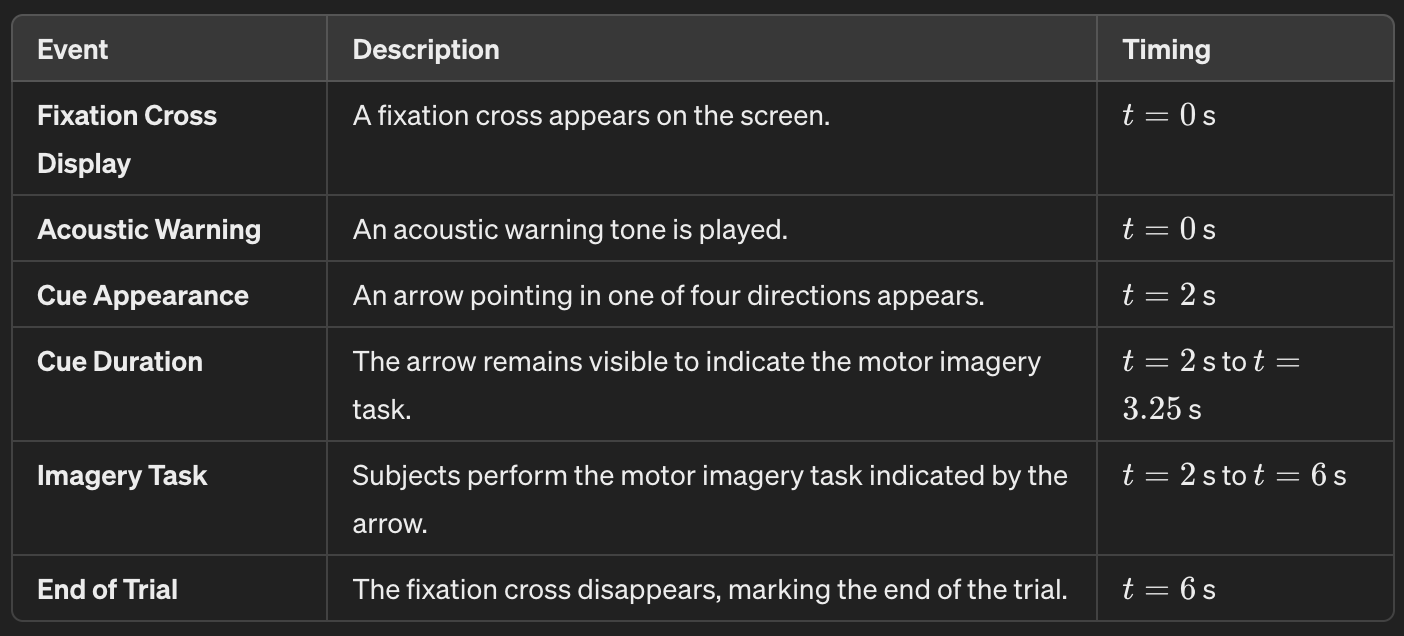

# EEG Recording Setup
EEG data were captured using 22 Ag/AgCl electrodes, arranged according to a specified montage (Figure 3, referenced in the original description), focusing on standard distances to optimize signal quality and spatial resolution.
The electrodes were connected monopolarly, with the left mastoid used as the reference point and the right mastoid as the ground.
The EEG signals were sampled at a frequency of 250 Hz and were bandpass filtered within a range of 0.5 Hz to 100 Hz to ensure clarity and reduce noise.
A 50 Hz notch filter was also applied to minimize electrical interference from power lines.(Tangermann et al., 2012)

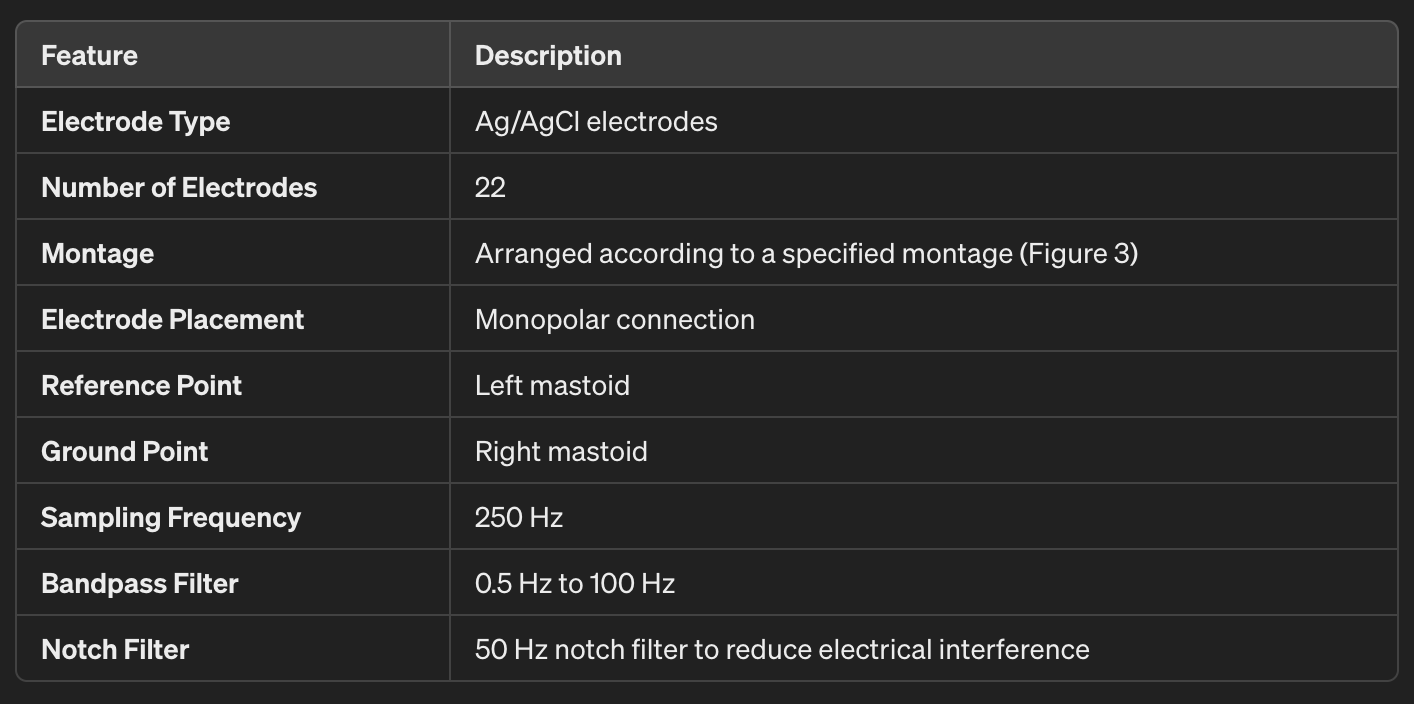

NOTE: all the images above are generated by ChatGPT to give a clear idea

the EEG data looks like below:

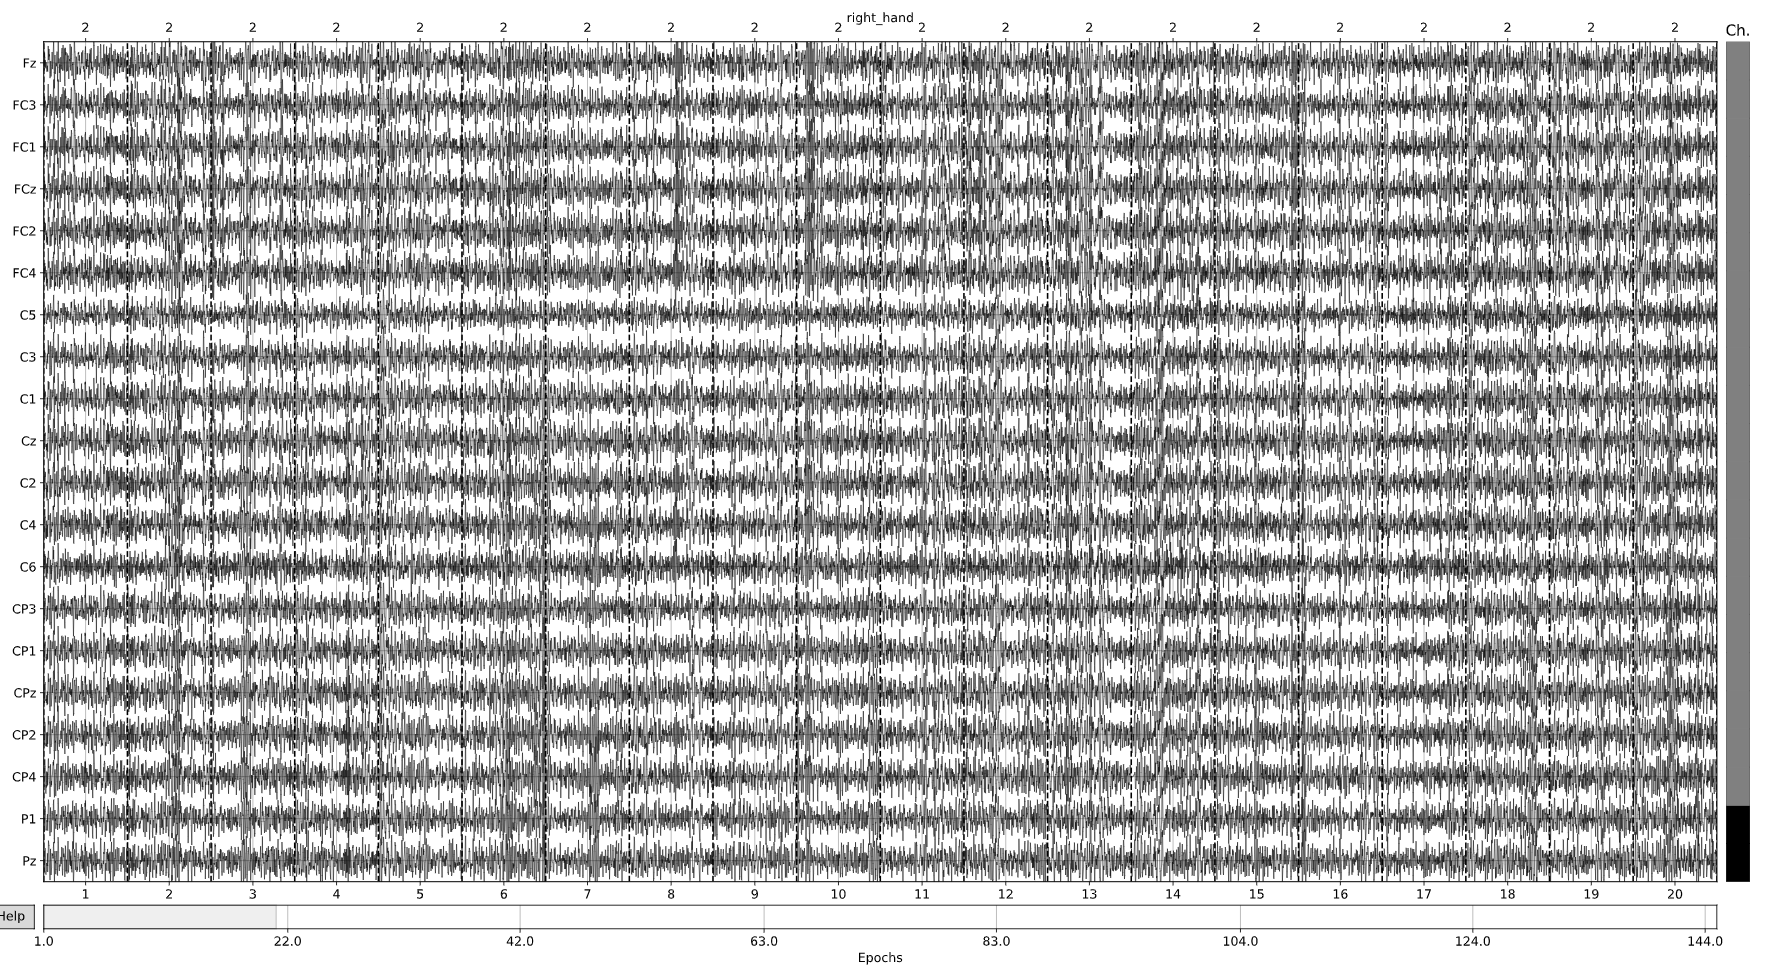

Image source: https://github.com/berdakh/eeg-pytorch/blob/master/visualization.ipynb

## **Experimental Results**
The result is based on performing the experiment on 100 epoches, all 9 subjects, 2 sessions and 10 different random seeds.




```
!./run_experiments.sh --hparams /content/example_hyperparams.yaml \
--data_folder '/content/data/BNCI2014001'\
--cached_data_folder '/content/data' \
--output_folder '/content/results/full-experiment/BNCI2014001' \
--nsbj 9 --nsess 2 --nruns 10 --train_mode 'leave-one-session-out' \
--number_of_epochs 100 \
--device 'cuda'
```



# Adding adaptive average pooling On EEGNET architecture

The 10 runs and the average aggregate results are below for adding a single adaptive average pooling layer:

Run 1 Aggregate Result: acc 0.44598765432098764 ± 0.015432098765432112

Run 2 Aggregate Result: acc 0.46508487654320985 ± 0.004822530864197511

Run 3 Aggregate Result: acc 0.4292052469135803 ± 0.007137345679012336

Run 4 Aggregate Result: acc 0.48206018518518523 ± 0.0028935185185185452

Run 5 Aggregate Result: acc 0.43113425925925924 ± 0.02449845679012347

Run 6 Aggregate Result: acc 0.41184413580246915 ± 0.004822530864197538

Run 7 Aggregate Result: acc 0.42476851851851855 ± 0.013888888888888895

Run 8 Aggregate Result: acc 0.47145061728395066 ± 0.001929012345679021

Run 9 Aggregate Result: acc 0.408179012345679 ± 0.011959876543209874

Run 10 Aggregate Result: acc 0.418159312345679 +- 0.011959876543209874

with an averge of : 0.43

# Adding attention layer and adaptive average pooling on EEGNET architecture

The 10 runs and the average aggregated result for attention layer and adaptive average pooling layer:

Run 1 Aggregate Result: acc 0.4908854166666667 ± 0.005642361111111105

Run 2 Aggregate Result: acc 0.48977623456790126 ± 0.013310185185185175

Run 3 Aggregate Result: acc 0.47723765432098764 ± 0.01890432098765432

Run 4 Aggregate Result: acc 0.5063657407407407 ± 0.01485339506172842

Run 5 Aggregate Result: acc 0.4828317901234568 ± 0.022183641975308643

Run 6 Aggregate Result: acc 0.48553240740740744 ± 0.001350308641975273

Run 7 Aggregate Result: acc 0.49344135802469136 ± 0.006172839506172811

Run 8 Aggregate Result: acc 0.5163966049382716 ± 0.02295524691358025

Run 9 Aggregate Result: acc 0.464891975308642 ± 0.0142746913580247

Run 10 Aggregate Result: acc 0.5156250000000001 ± 0.012538580246913567

with an average of 50% (0.492298 ± 0.015639)

In the end I select the second model as 'MyModel', since it achieves higher result

# Result Analysis


In above two models, comparing the inclusion of only an adaptive average pooling layer to the combined addition of an adaptive average pooling layer and an attention layer reveals significant differences in performance and efficiency. Adaptive average pooling alone simplifies the model by reducing spatial dimensions and computational load, which helps in managing large datasets but often at the cost of losing potentially valuable information. On the other hand, introducing an attention layer alongside adaptive pooling fundamentally enhances the network's ability to selectively prioritize and process the most informative features before they are aggregated. This dual-layer setup not only retains critical data during dimensionality reduction but also adapts dynamically to focus on salient features, leading to improved model accuracy and robustness against overfitting. However, this enhancement in capability comes with increased computational complexity and the need for more nuanced hyperparameter tuning to balance efficiency with performance effectively.

# Hyperparameter Tuning Result for MyModel

fmin: 1.8

fmax: 28.8

Number of Epochs: 141

Learning Rate (lr): 0.0005

Batch Size: 32

Max Learning Rate: 0.0005

Base Learning Rate: 0.00000001

Step Size Multiplier: 5

Step Size: Computed as round(5 * n_train_examples / batch_size)

Label Smoothing: 0.0

CNN Temporal Kernels: 26

CNN Temporal Kernel Size: [51, 1]

CNN Spatial Depth Multiplier: 2

CNN Spatial Max Norm: 1.0

CNN Spatial Pool Size: [4, 1]

CNN Septemporal Depth Multiplier: 1

CNN Septemporal Point Kernels: Computed as cnn_temporal_kernels * cnn_spatial_depth_multiplier * cnn_septemporal_depth_multiplier

CNN Septemporal Kernel Size: [16, 1]

CNN Septemporal Pool Size: [8, 1]

CNN Pool Type: 'avg'

Dense Max Norm: 0.25

Dropout Rate: 0.5

Activation Type: 'elu'

Number of Output Neurons (Dense Neurons): 4 (referring to n_classes)

Dimensions to Normalize: 1 (time dimension)


Above result is achieved through below configurations:



```
!./run_hparam_optimization.sh --hparams '/content/sample_hyperparams.yaml' \
--data_folder '/content/data/BNCI2014001'\
--cached_data_folder '/content/data' \
--output_folder '/content/results/hyperparameter-search/BNCI2014001' \
--nsbj 9 --nsess 2 --nruns 10 --train_mode 'leave-one-session-out' \
--exp_name 'hyperparameter-search' \
--nsbj_hpsearch 9 --nsess_hpsearch 2 \
--nruns_eval 2 \
--eval_metric acc \
--exp_max_trials 5
```



## **Conclusions**

In conclusion, the integration of both an attention layer and an adaptive average pooling layer significantly enhances performance compared to using only a single adaptive pooling layer. By incorporating an additional layer, the second model achieves an 8% improvement in performance. The process of hyperparameter tuning is essential in training machine learning models, as it can markedly enhance the results compared to models without this adjustment. Although MyModel does not surpass the performance of the EEGNet architecture, I am quite satisfied with its approximate 50% performance outcome.



## **References**
1. MDPI. (2023). Electroencephalography Signal Processing: A Comprehensive Review and Analysis of Methods and Techniques. Sensors, 23(14), 6434. https://www.mdpi.com/1424-8220/23/14/6434
2. Ding, E., Cheng, Y., Xiao, C., Liu, Z., & Yu, W. (2021). Efficient Attention Mechanism for Dynamic Convolution in Lightweight Neural Network. Applied Sciences, 11(7), 3111. https://doi.org/10.3390/app11073111
3. Tangermann, M., Müller, K. R., Aertsen, A., Birbaumer, N., Braun, C., Brunner, C., Leeb, R., Mehring, C., Miller, K. J., Mueller-Putz, G., & Nolte, G. (2012). Review of the BCI competition IV. Frontiers in Neuroscience, 6, 55. https://doi.org/10.3389/fnins.2012.00055
4.Lawhern, V. J., Solon, A. J., Waytowich, N. R., Gordon, S. M., Hung, C. P., & Lance, B. J. (2018). EEGNet: a compact convolutional neural network for EEG-based brain-computer interfaces. Journal of Neural Engineering, 15(5), 056013.
5. Waytowich, N. R., Lawhern, V. J., Garcia, J. O., Cummings, J., Faller, J., Sajda, P., & Vettel, J. M. (2018). Compact convolutional neural networks for classification of asynchronous steady-state visual evoked potentials. Journal of Neural Engineering, 15(6), 066031. https://doi.org/10.1088/1741-2552/aad8e6
6. Schirrmeister, R. T., Springenberg, J. T., Fiederer, L. D. J., Glasstetter, M., Eggensperger, K., Tangermann, M., Hutter, F., Burgard, W., & Ball, T. (2017). Deep learning with convolutional neural networks for EEG decoding and visualization. Human Brain Mapping, 38(11), 5391-5420. https://doi.org/10.1002/hbm.23730
7. Li, X., Chen, Y., Nakanishi, M., & Jung, T. P. (2020). Convolutional correlation analysis for enhancing the performance of SSVEP-based brain-computer interface. IEEE Transactions on Neural Systems and Rehabilitation Engineering, 28(9), 1989-1998. https://doi.org/10.1109/TNSRE.2020.3019662
8. Chen, X., Wang, Y., Nakanishi, M., Gao, X., Jung, T. P., & Gao, S. (2022). FB-SSVEPformer: An enhanced filter bank canonical correlation analysis with transformer for SSVEP-based brain-computer interface. Journal of Neural Engineering, 19(3), 036021. https://doi.org/10.1088/1741-2552/ac739b

# **Code Section**

In [ ]:
%%writefile /content/benchmarks/benchmarks/MOABB/models/mymodel.py
"""EEGNet from https://doi.org/10.1088/1741-2552/aace8c.
Shallow and lightweight convolutional neural network proposed for a general decoding of single-trial EEG signals.
It was proposed for P300, error-related negativity, motor execution, motor imagery decoding.

Original Authors
 * Davide Borra, 2021

Person who modifies EEGNet
 * Zixin Deng, 2024
"""
import torch
import speechbrain as sb
from speechbrain.nnet.attention import PositionalwiseFeedForward
from speechbrain.nnet.normalization import BatchNorm1d

class EEGNetEnhenced(torch.nn.Module):
    """EEGNet.

    Arguments
    ---------
    input_shape: tuple
        The shape of the input.
    cnn_temporal_kernels: int
        Number of kernels in the 2d temporal convolution.
    cnn_temporal_kernelsize: tuple
        Kernel size of the 2d temporal convolution.
    cnn_spatial_depth_multiplier: int
        Depth multiplier of the 2d spatial depthwise convolution.
    cnn_spatial_max_norm: float
        Kernel max norm of the 2d spatial depthwise convolution.
    cnn_spatial_pool: tuple
        Pool size and stride after the 2d spatial depthwise convolution.
    cnn_septemporal_depth_multiplier: int
        Depth multiplier of the 2d temporal separable convolution.
    cnn_septemporal_kernelsize: tuple
        Kernel size of the 2d temporal separable convolution.
    cnn_septemporal_pool: tuple
        Pool size and stride after the 2d temporal separable convolution.
    cnn_pool_type: string
        Pooling type.
    dropout: float
        Dropout probability.
    dense_max_norm: float
        Weight max norm of the fully-connected layer.
    dense_n_neurons: int
        Number of output neurons.
    activation_type: str
        Activation function of the hidden layers.

    Example
    -------
    #>>> inp_tensor = torch.rand([1, 200, 32, 1])
    #>>> model = EEGNet(input_shape=inp_tensor.shape)
    #>>> output = model(inp_tensor)
    #>>> output.shape

    #torch.Size([1,4])
    """

    def __init__(
        self,
        input_shape=None,  # (1, T, C, 1)
        cnn_temporal_kernels=8,
        cnn_temporal_kernelsize=(33, 1),
        cnn_spatial_depth_multiplier=2,
        cnn_spatial_max_norm=1.0,
        cnn_spatial_pool=(4, 1),
        cnn_septemporal_depth_multiplier=1,
        cnn_septemporal_point_kernels=None,
        cnn_septemporal_kernelsize=(17, 1),
        cnn_septemporal_pool=(8, 1),
        cnn_pool_type="avg",
        dropout=0.5,
        dense_max_norm=0.25,
        dense_n_neurons=4,
        activation_type="elu",


    ):
        super().__init__()
        if input_shape is None:
            raise ValueError("Must specify input_shape")
        if activation_type == "gelu":
            activation = torch.nn.GELU()
        elif activation_type == "elu":
            activation = torch.nn.ELU()
        elif activation_type == "relu":
            activation = torch.nn.ReLU()
        elif activation_type == "leaky_relu":
            activation = torch.nn.LeakyReLU()
        elif activation_type == "prelu":
            activation = torch.nn.PReLU()
        else:
            raise ValueError("Wrong hidden activation function")
        self.default_sf = 128  # sampling rate of the original publication (Hz)
        # T = input_shape[1]
        C = input_shape[2]

        # CONVOLUTIONAL MODULE
        self.conv_module = torch.nn.Sequential()
        # Temporal convolution
        self.conv_module.add_module(
            "conv_0",
            sb.nnet.CNN.Conv2d(
                in_channels=1,
                out_channels=cnn_temporal_kernels,
                kernel_size=cnn_temporal_kernelsize,
                padding="same",
                padding_mode="constant",
                bias=False,
                swap=True,
            ),
        )
        self.conv_module.add_module(
            "bnorm_0",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_temporal_kernels, momentum=0.01, affine=True,
            ),
        )
        # Spatial depthwise convolution
        cnn_spatial_kernels = (
            cnn_spatial_depth_multiplier * cnn_temporal_kernels
        )
        self.conv_module.add_module(
            "conv_1",
            sb.nnet.CNN.Conv2d(
                in_channels=cnn_temporal_kernels,
                out_channels=cnn_spatial_kernels,
                kernel_size=(1, C),
                groups=cnn_temporal_kernels,
                padding="valid",
                bias=False,
                max_norm=cnn_spatial_max_norm,
                swap=True,
            ),
        )
        self.conv_module.add_module(
            "bnorm_1",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_spatial_kernels, momentum=0.01, affine=True,
            ),
        )
        self.conv_module.add_module("act_1", activation)
        self.conv_module.add_module(
            "pool_1",
            sb.nnet.pooling.Pooling2d(
                pool_type=cnn_pool_type,
                kernel_size=cnn_spatial_pool,
                stride=cnn_spatial_pool,
                pool_axis=[1, 2],
            ),
        )
        self.conv_module.add_module("dropout_1", torch.nn.Dropout(p=dropout))


        # Temporal separable convolution
        cnn_septemporal_kernels = (
            cnn_spatial_kernels * cnn_septemporal_depth_multiplier
        )
        self.conv_module.add_module(
            "conv_2",
            sb.nnet.CNN.Conv2d(
                in_channels=cnn_spatial_kernels,
                out_channels=cnn_septemporal_kernels,
                kernel_size=cnn_septemporal_kernelsize,
                groups=cnn_spatial_kernels,
                padding="same",
                padding_mode="constant",
                bias=False,
                swap=True,
            ),
        )

        if cnn_septemporal_point_kernels is None:
            cnn_septemporal_point_kernels = cnn_septemporal_kernels

        self.conv_module.add_module(
            "conv_3",
            sb.nnet.CNN.Conv2d(
                in_channels=cnn_septemporal_kernels,
                out_channels=cnn_septemporal_point_kernels,
                kernel_size=(1, 1),
                padding="valid",
                bias=False,
                swap=True,
            ),
        )
        self.conv_module.add_module(
            "bnorm_3",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_septemporal_point_kernels,
                momentum=0.01,
                affine=True,
            ),
        )
        self.conv_module.add_module("act_3", activation)
        self.conv_module.add_module(
            "pool_3",
            sb.nnet.pooling.Pooling2d(
                pool_type=cnn_pool_type,
                kernel_size=cnn_septemporal_pool,
                stride=cnn_septemporal_pool,
                pool_axis=[1, 2],
            ),
        )
        self.conv_module.add_module("dropout_3", torch.nn.Dropout(p=dropout))



        self.conv_module.add_module("gap", torch.nn.AdaptiveAvgPool2d((1, 1)))
        # Shape of intermediate feature maps
        out = self.conv_module(
            torch.ones((1,) + tuple(input_shape[1:-1]) + (1,))
        )
        dense_input_size = self._num_flat_features(out)




        #ATTENTION MODULE
        self.attention_module = torch.nn.Sequential()
        self.attention_module.add_module(
         'atten', PositionalwiseFeedForward(25, input_size=1),
        )



        # DENSE MODULE
        self.dense_module = torch.nn.Sequential()
        self.dense_module.add_module(
            "flatten", torch.nn.Flatten(),
        )
        self.dense_module.add_module(
            "fc_out",
            sb.nnet.linear.Linear(
                input_size=dense_input_size,
                n_neurons=dense_n_neurons,
                max_norm=dense_max_norm,
            ),
        )
        self.dense_module.add_module("act_out", torch.nn.LogSoftmax(dim=1))

    def _num_flat_features(self, x):
        """Returns the number of flattened features from a tensor.

        Arguments
        ---------
        x : torch.Tensor
            Input feature map.
        """

        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def forward(self, x):
        """Returns the output of the model.

        Arguments
        ---------
        x : torch.Tensor (batch, time, EEG channel, channel)
            Input to convolve. 4d tensors are expected.
        """

        x = self.conv_module(x)

    # Check dimensions after GAP, adjust if necessary
        if x.ndim > 3:
          x = torch.squeeze(x, -1)  # Squeeze the spatial dimension if it's still present
        if x.ndim < 3:
          x = x.unsqueeze(-1)

        x = self.attention_module(x)

       # x= self.attention_module(x)


        x = self.dense_module(x)
        return x

Writing /content/benchmarks/benchmarks/MOABB/models/mymodel.py


In [ ]:
from hyperpyyaml import load_hyperpyyaml, dump_hyperpyyaml

example_hyperparams = """

seed: 1234
__set_torchseed: !apply:torch.manual_seed [!ref <seed>]

# DIRECTORIES
data_folder: !PLACEHOLDER  #'/path/to/dataset'. The dataset will be automatically downloaded in this folder
cached_data_folder: !PLACEHOLDER #'path/to/pickled/dataset'
output_folder: !PLACEHOLDER #'path/to/results'

# DATASET HPARS
# Defining the MOABB dataset.
dataset: !new:moabb.datasets.BNCI2014001
save_prepared_dataset: True # set to True if you want to save the prepared dataset as a pkl file to load and use afterwards
data_iterator_name: !PLACEHOLDER
target_subject_idx: !PLACEHOLDER
target_session_idx: !PLACEHOLDER
events_to_load: null # all events will be loaded
original_sample_rate: 250 # Original sampling rate provided by dataset authors
sample_rate: 125 # Target sampling rate (Hz)
# band-pass filtering cut-off frequencies
fmin: 1.8 # @orion_step1: --fmin~"uniform(0.1, 5, precision=2)"
fmax: 28.8 # @orion_step1: --fmax~"uniform(20.0, 50.0, precision=3)"
n_classes: 4
# tmin, tmax respect to stimulus onset that define the interval attribute of the dataset class
# trial begins (0 s), cue (2 s, 1.25 s long); each trial is 6 s long
# dataset interval starts from 2
# -->tmin tmax are referred to this start value (e.g., tmin=0.5 corresponds to 2.5 s)
tmin: 0.
tmax: 4.0 # @orion_step1: --tmax~"uniform(1.0, 4.0, precision=2)"
# number of steps used when selecting adjacent channels from a seed channel (default at Cz)
n_steps_channel_selection: 3 # @orion_step1: --n_steps_channel_selection~"uniform(1, 3,discrete=True)"
T: !apply:math.ceil
    - !ref <sample_rate> * (<tmax> - <tmin>)
C: 22
# We here specify how to perfom test:
# - If test_with: 'last' we perform test with the latest model.
# - if test_with: 'best, we perform test with the best model (according to the metric specified in test_key)
# The variable avg_models can be used to average the parameters of the last (or best) N saved models before testing.
# This can have a regularization effect. If avg_models: 1, the last (or best) model is used directly.
test_with: 'last' # 'last' or 'best'
test_key: "acc" # Possible opts: "loss", "f1", "auc", "acc"

# METRICS
f1: !name:sklearn.metrics.f1_score
    average: 'macro'
acc: !name:sklearn.metrics.balanced_accuracy_score
cm: !name:sklearn.metrics.confusion_matrix
metrics:
    f1: !ref <f1>
    acc: !ref <acc>
    cm: !ref <cm>
# TRAINING HPARS
n_train_examples: 100  # it will be replaced in the train script
# checkpoints to average
avg_models: 10 # @orion_step1: --avg_models~"uniform(1, 15,discrete=True)"
number_of_epochs: 141 # @orion_step1: --number_of_epochs~"uniform(250, 1000, discrete=True)"
lr: 0.0005 # @orion_step1: --lr~"choices([0.01, 0.005, 0.001, 0.0005, 0.0001])"
# Learning rate scheduling (cyclic learning rate is used here)
max_lr: !ref <lr> # Upper bound of the cycle (max value of the lr)
base_lr: 0.00000001 # Lower bound in the cycle (min value of the lr)
step_size_multiplier: 5 #from 2 to 8
step_size: !apply:round
    - !ref <step_size_multiplier> * <n_train_examples> / <batch_size>
lr_annealing: !new:speechbrain.nnet.schedulers.CyclicLRScheduler
    base_lr: !ref <base_lr>
    max_lr: !ref <max_lr>
    step_size: !ref <step_size>
label_smoothing: 0.0
loss: !name:speechbrain.nnet.losses.nll_loss
    label_smoothing: !ref <label_smoothing>
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter  # epoch counter
    limit: !ref <number_of_epochs>
batch_size_exponent: 4 # @orion_step1: --batch_size_exponent~"uniform(4, 6,discrete=True)"
batch_size: !ref 2 ** <batch_size_exponent>
valid_ratio: 0.2

# DATA AUGMENTATION
# cutcat (disabled when min_num_segments=max_num_segments=1)
max_num_segments: 3 # @orion_step2: --max_num_segments~"uniform(2, 6, discrete=True)"
cutcat: !new:speechbrain.augment.time_domain.CutCat
    min_num_segments: 2
    max_num_segments: !ref <max_num_segments>
# random amplitude gain between 0.5-1.5 uV (disabled when amp_delta=0.)
amp_delta: 0.01742 # @orion_step2: --amp_delta~"uniform(0.0, 0.5)"
rand_amp: !new:speechbrain.augment.time_domain.RandAmp
    amp_low: !ref 1 - <amp_delta>
    amp_high: !ref 1 + <amp_delta>
# random shifts between -300 ms to 300 ms (disabled when shift_delta=0.)
shift_delta_: 1 # orion_step2: --shift_delta_~"uniform(0, 25, discrete=True)"
shift_delta: !ref 1e-2 * <shift_delta_> # 0.250 # 0.-0.25 with steps of 0.01
min_shift: !apply:math.floor
    - !ref 0 - <sample_rate> * <shift_delta>
max_shift: !apply:math.floor
    - !ref 0 + <sample_rate> * <shift_delta>
time_shift: !new:speechbrain.augment.freq_domain.RandomShift
    min_shift: !ref <min_shift>
    max_shift: !ref <max_shift>
    dim: 1
# injection of gaussian white noise
snr_white_low: 15.0 # @orion_step2: --snr_white_low~"uniform(0.0, 15, precision=2)"
snr_white_delta: 19.1 # @orion_step2: --snr_white_delta~"uniform(5.0, 20.0, precision=3)"
snr_white_high: !ref <snr_white_low> + <snr_white_delta>
add_noise_white: !new:speechbrain.augment.time_domain.AddNoise
    snr_low: !ref <snr_white_low>
    snr_high: !ref <snr_white_high>

repeat_augment: 1 # @orion_step1: --repeat_augment 0
augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    parallel_augment_fixed_bs: True
    repeat_augment: !ref <repeat_augment>
    shuffle_augmentations: True
    min_augmentations: 4
    max_augmentations: 4
    augmentations: [
        !ref <cutcat>,
        !ref <rand_amp>,
        !ref <time_shift>,
        !ref <add_noise_white>]

# DATA NORMALIZATION
dims_to_normalize: 1 # 1 (time) or 2 (EEG channels)
normalize: !name:speechbrain.processing.signal_processing.mean_std_norm
    dims: !ref <dims_to_normalize>
# MODEL
input_shape: [null, !ref <T>, !ref <C>, null]
cnn_temporal_kernels: 26 # @orion_step1: --cnn_temporal_kernels~"uniform(4, 64,discrete=True)"
cnn_temporal_kernelsize: 51 # @orion_step1: --cnn_temporal_kernelsize~"uniform(24, 62,discrete=True)"
# depth multiplier for the spatial depthwise conv. layer
cnn_spatial_depth_multiplier: 2 # @orion_step1: --cnn_spatial_depth_multiplier~"uniform(1, 4,discrete=True)"
cnn_spatial_max_norm: 1.  # kernel max-norm constaint of the spatial depthwise conv. layer
cnn_spatial_pool: 4
cnn_septemporal_depth_multiplier: 1  # depth multiplier for the separable temporal conv. layer
cnn_septemporal_point_kernels_ratio_: 7 # @orion_step1: --cnn_septemporal_point_kernels_ratio_~"uniform(0, 8, discrete=True)"
cnn_septemporal_point_kernels_ratio: !ref <cnn_septemporal_point_kernels_ratio_> / 4
## number of temporal filters in the separable temporal conv. layer
cnn_septemporal_point_kernels_: !ref <cnn_temporal_kernels> * <cnn_spatial_depth_multiplier> * <cnn_septemporal_depth_multiplier>
cnn_septemporal_point_kernels: !apply:math.ceil
    - !ref <cnn_septemporal_point_kernels_ratio> * <cnn_septemporal_point_kernels_> + 1
cnn_septemporal_kernelsize_: 16 # @orion_step1: --cnn_septemporal_kernelsize_~"uniform(3, 24,discrete=True)"
max_cnn_spatial_pool: 4
cnn_septemporal_kernelsize: !apply:round
    - !ref <cnn_septemporal_kernelsize_> * <max_cnn_spatial_pool> / <cnn_spatial_pool>
cnn_septemporal_pool: 8 # @orion_step1: --cnn_septemporal_pool~"uniform(1, 8,discrete=True)"
cnn_pool_type: 'avg'
dense_max_norm: 0.25  # kernel max-norm constaint of the dense layer
dropout: 0.5 # @orion_step1: --dropout~"uniform(0.0, 0.5)"
activation_type: 'elu'

model: !new:models.mymodel.EEGNetEnhenced
    input_shape: !ref <input_shape>
    cnn_temporal_kernels: !ref <cnn_temporal_kernels>
    cnn_temporal_kernelsize: [!ref <cnn_temporal_kernelsize>, 1]
    cnn_spatial_depth_multiplier: !ref <cnn_spatial_depth_multiplier>
    cnn_spatial_max_norm: !ref <cnn_spatial_max_norm>
    cnn_spatial_pool: [!ref <cnn_spatial_pool>, 1]
    cnn_septemporal_depth_multiplier: !ref <cnn_septemporal_depth_multiplier>
    cnn_septemporal_point_kernels: !ref <cnn_septemporal_point_kernels>
    cnn_septemporal_kernelsize: [!ref <cnn_septemporal_kernelsize>, 1]
    cnn_septemporal_pool: [!ref <cnn_septemporal_pool>, 1]
    cnn_pool_type: !ref <cnn_pool_type>
    activation_type: !ref <activation_type>
    dense_max_norm: !ref <dense_max_norm>
    dropout: !ref <dropout>
    dense_n_neurons: !ref <n_classes>

"""

In [ ]:
# Save the yaml file on disk
f = open('/content/example_hyperparams.yaml', "w")
f.write(example_hyperparams)
f.close()

In [ ]:
%cd /content/benchmarks/benchmarks/MOABB/
!./run_experiments.sh --hparams /content/example_hyperparams.yaml \
--data_folder '/content/data/BNCI2014001'\
--cached_data_folder '/content/data' \
--output_folder '/content/results/full-experiment/BNCI2014001' \
--nsbj 9 --nsess 2 --nruns 10 --train_mode 'leave-one-session-out' \
--number_of_epochs 100 \
--device 'cuda'

/content/benchmarks/benchmarks/MOABB
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
2024-04-26 00:10:37.948041: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-26 0